In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.feature_selection import f_classif

In [35]:
df = pd.read_csv('../src/data/gold/teste_indicium_precificacao_OHE.csv')
data = df.copy()

In [36]:
data.head(3)

,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,media_bairro,bairro_group_Bronx,bairro_group_Brooklyn,bairro_group_Manhattan,bairro_group_Queens,bairro_group_Staten Island,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,2845,40.75356,-73.98559,240.0,30,49,0.27,3,365,298.062842,0,0,1,0,0,1,0,0,0
1,15991,40.70935,-73.95342,81.0,30,195,1.03,1,196,154.551365,0,1,0,0,0,1,0,0,0
2,16104,40.80107,-73.94255,65.0,30,1,0.03,2,83,133.806283,0,0,1,0,0,0,0,1,0


In [37]:
data['media_bairro'].describe()
data.drop(['host_id'], axis=1, inplace=True)

# Precisamos entender nossa variável alvo e como os dados se organizam no nosso dataset

In [38]:
data.describe()

,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,media_bairro,bairro_group_Bronx,bairro_group_Brooklyn,bairro_group_Manhattan,bairro_group_Queens,bairro_group_Staten Island,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
count,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000
mean,40.728594,-73.949976,165.913266,13.235799,26.635964,1.012093,35.691036,154.254143,165.913266,0.028088,0.391621,0.443022,0.127693,0.009577,0.531515,0.004300,0.447196,0.016989
std,0.055788,0.050418,272.144287,22.729984,56.151792,1.728891,157.643977,140.120584,66.017313,0.165224,0.488116,0.496746,0.333749,0.097391,0.499009,0.065431,0.497207,0.129232
min,40.499790,-74.251907,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,52.025641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.688830,-73.983180,70.000000,2.000000,1.000000,0.020000,1.000000,1.000000,117.580512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.724050,-73.955230,117.000000,3.000000,5.000000,0.310000,1.000000,126.000000,148.314554,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,40.762964,-73.932340,190.000000,30.000000,27.000000,1.360000,3.000000,299.000000,210.429130,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,40.913060,-73.712990,20000.000000,1250.000000,2485.000000,116.300000,1154.000000,365.000000,700.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


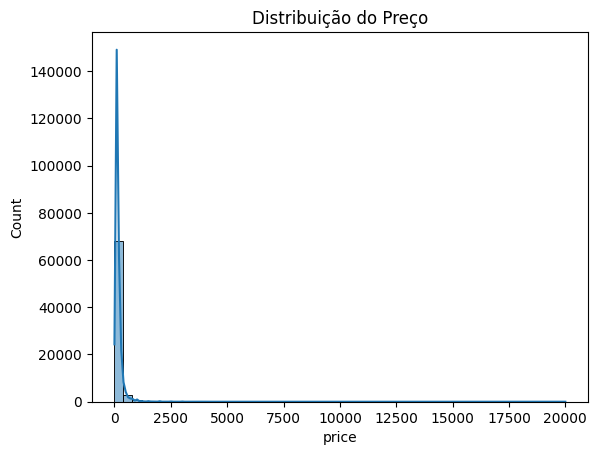

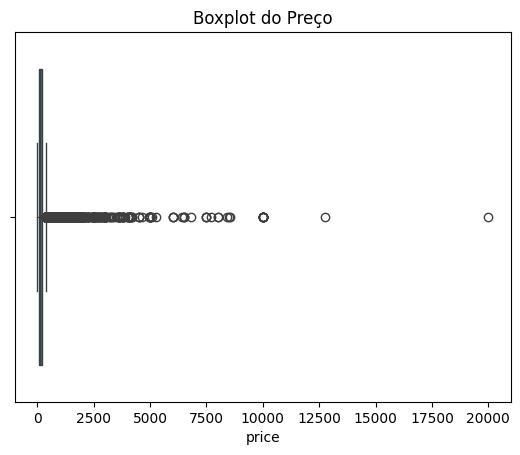

In [39]:
sns.histplot(data['price'], bins=50, kde=True)
plt.title('Distribuição do Preço')
plt.show()

sns.boxplot(x=data['price'])
plt.title('Boxplot do Preço')
plt.show()

## A distribuição do preço está muito irregular, com muitos dados proximos de 0

Algumas abordagens podem ser aplicadas:
* Transformação Logarítmica

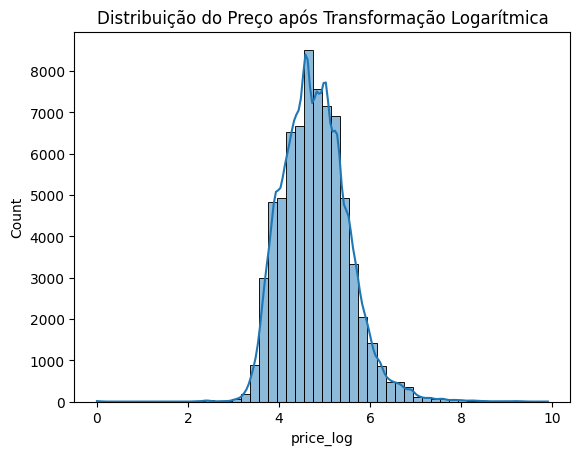

In [40]:
data['price_log'] = np.log1p(data['price'])  # log(1 + price) para evitar log(0)

# Para reverter para o valor original
# data['price_reverted'] = np.expm1(data['price_log'])

sns.histplot(data['price_log'], bins=50, kde=True)
plt.title('Distribuição do Preço após Transformação Logarítmica')
plt.show()


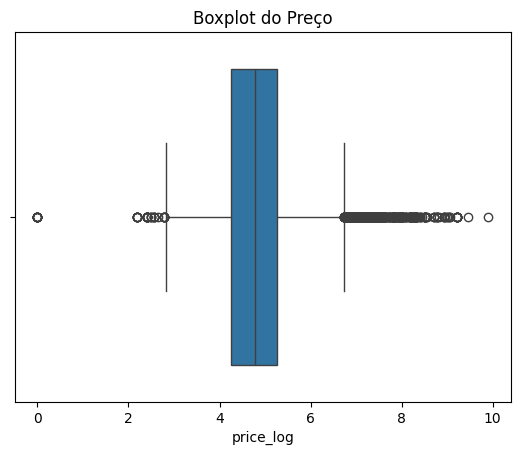

In [41]:
sns.boxplot(x=data['price_log'])
plt.title('Boxplot do Preço')
plt.show()

# Criação do modelo e testes de acurácia e precisão

In [42]:
data.to_csv('../src/data/gold/teste_indicium_precificacao_OHE_log.csv', index=False)

## Como nosso objetivo é 1 variável alvo numérica e de predição, utilizaremos um modelo regressor

In [54]:
data.describe()

,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,media_bairro,bairro_group_Bronx,bairro_group_Brooklyn,bairro_group_Manhattan,bairro_group_Queens,bairro_group_Staten Island,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,price_log
count,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000,71633.000000
mean,40.728594,-73.949976,165.913266,13.235799,26.635964,1.012093,35.691036,154.254143,165.913266,0.028088,0.391621,0.443022,0.127693,0.009577,0.531515,0.004300,0.447196,0.016989,4.799375
std,0.055788,0.050418,272.144287,22.729984,56.151792,1.728891,157.643977,140.120584,66.017313,0.165224,0.488116,0.496746,0.333749,0.097391,0.499009,0.065431,0.497207,0.129232,0.717644
min,40.499790,-74.251907,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,52.025641,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.688830,-73.983180,70.000000,2.000000,1.000000,0.020000,1.000000,1.000000,117.580512,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.262680
50%,40.724050,-73.955230,117.000000,3.000000,5.000000,0.310000,1.000000,126.000000,148.314554,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.770685
75%,40.762964,-73.932340,190.000000,30.000000,27.000000,1.360000,3.000000,299.000000,210.429130,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,5.252273
max,40.913060,-73.712990,20000.000000,1250.000000,2485.000000,116.300000,1154.000000,365.000000,700.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.903538


In [43]:
x_data = data.drop(columns=['price','price_log'])
y_data = data['price_log']

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)


### Seleção de variáveis com chi2 e ANOVA
* Variáveis com p-value >= 0,05 (ou 5%) não representam muita significância para a variável alvo, que no caso seria a latitude

In [61]:
f_statistic, p_values = f_classif(x_train, y_train)

resultados = pd.DataFrame({
    'Variável': x_train.columns,
    'Estatística F': f_statistic,
    'Valor p': p_values
})

# Ordenar pelos valores p
resultados_ordenados = resultados.sort_values(by='Valor p')

pd.DataFrame(resultados_ordenados)

,Variável,Estatística F,Valor p
1,longitude,6.176213,0.000000e+00
7,media_bairro,20.171462,0.000000e+00
6,disponibilidade_365,4.475068,0.000000e+00
5,calculado_host_listings_count,17.346204,0.000000e+00
13,room_type_Entire home/apt,43.746689,0.000000e+00
14,room_type_Hotel room,15.014333,0.000000e+00
15,room_type_Private room,38.439948,0.000000e+00
10,bairro_group_Manhattan,8.674838,0.000000e+00
16,room_type_Shared room,7.088538,0.000000e+00
9,bairro_group_Brooklyn,3.092586,2.600284e-185


In [45]:
x_train.drop(columns=['latitude'], inplace=True)
x_test.drop(columns=['latitude'], inplace=True)

### Grid Search para melhorar hiperparâmetros

### Regressão Lasso

In [46]:
model_Lasso = Lasso()
param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0]}
grid_search = GridSearchCV(model_Lasso, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Executando o Grid Search
grid_search.fit(x_train, y_train)

print("Melhores parâmetros:", grid_search.best_params_)

best_lasso = grid_search.best_estimator_

y_pred = best_lasso.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Exibindo os resultados
print("\nAvaliação do Modelo no Conjunto de Teste:")
print("MAE  :", mae)
print("MSE  :", mse)
print("RMSE :", rmse)
print("R²   :", r2)

Melhores parâmetros: {'alpha': 0.01}

Avaliação do Modelo no Conjunto de Teste:
MAE  : 0.3869942989508344
MSE  : 0.2737514809916098
RMSE : 0.523212653699822
R²   : 0.4570954505833267


In [47]:
# Teste do modelo
model_Lasso = Lasso(alpha=0.01)
model_Lasso.fit(x_train, y_train)

y_pred = model_Lasso.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


MAE: 0.39
MSE: 0.27
RMSE: 0.52
R² Score: 0.46


### LGBM

In [48]:
model_lgbm = lgb.LGBMRegressor()
param_grid = {
    "num_leaves": [15, 31, 63],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [50, 100, 200]
}
grid_search = GridSearchCV(model_lgbm, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Executando o Grid Search
grid_search.fit(x_train, y_train)

print("Melhores parâmetros:", grid_search.best_params_)

best_lgbm = grid_search.best_estimator_

y_pred = best_lgbm.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Exibindo os resultados
print("\nAvaliação do Modelo no Conjunto de Teste:")
print("MAE  :", mae)
print("MSE  :", mse)
print("RMSE :", rmse)
print("R²   :", r2)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1391
[LightGBM] [Info] Number of data points in the train set: 50143, number of used features: 16
[LightGBM] [Info] Start training from score 4.800572
Melhores parâmetros: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 63}

Avaliação do Modelo no Conjunto de Teste:
MAE  : 0.3246458163592215
MSE  : 0.20180553738480642
RMSE : 0.4492277121736886
R²   : 0.5997788068695566


In [58]:
model_LGBM = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.1, num_leaves=63)
model_LGBM.fit(x_train, y_train)

y_pred = model_LGBM.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) 
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1646
[LightGBM] [Info] Number of data points in the train set: 50143, number of used features: 17
[LightGBM] [Info] Start training from score 4.800572
MAE: 0.32
MSE: 0.20
RMSE: 0.45
R² Score: 0.61


### Random Forest

In [18]:
rf_reg = RandomForestRegressor(random_state=42)

# Definição da grade de hiperparâmetros
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [None, 10],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}

grid_search = GridSearchCV(rf_reg, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

grid_search.fit(x_train, y_train)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(x_test)

mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

print("Melhores parâmetros:", grid_search.best_params_)
print("\nAvaliação do Modelo Random Forest no Conjunto de Teste:")
print("MAE  :", mae)
print("MSE  :", mse)
print("RMSE :", rmse)
print("R²   :", r2)

Melhores parâmetros: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Avaliação do Modelo Random Forest no Conjunto de Teste:
MAE  : 0.32033826171690766
MSE  : 0.20124611943603232
RMSE : 0.44860463599480593
R²   : 0.6008882457968445


In [55]:
rf_model = RandomForestRegressor(n_estimators=100,max_depth=None,min_samples_leaf=1,min_samples_split=2, random_state=42)
rf_model.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 0.32
MSE: 0.20
RMSE: 0.45
R² Score: 0.60


### XGboost

In [50]:

xgb_reg_search = xgb.XGBRegressor(objective="reg:squarederror")
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [50, 100, 200]
}

grid_search = GridSearchCV(xgb_reg_search, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Executando o Grid Search
grid_search.fit(x_train, y_train)

# Exibindo os melhores parâmetros encontrados
print("Melhores parâmetros:", grid_search.best_params_)

# Selecionando o melhor modelo encontrado
best_xgb = grid_search.best_estimator_

# Realizando previsões no conjunto de teste
y_pred = best_xgb.predict(x_test)

# Cálculo das métricas
mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

# Exibindo os resultados
print("\nAvaliação do Modelo XGBoost no Conjunto de Teste:")
print("MAE  :", mae)
print("MSE  :", mse)
print("RMSE :", rmse)
print("R²   :", r2)

Melhores parâmetros: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}

Avaliação do Modelo XGBoost no Conjunto de Teste:
MAE  : 0.32319036286797914
MSE  : 0.2006960315573964
RMSE : 0.4479911065606062
R²   : 0.6019791813081653


In [59]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

xg_reg = xgb.XGBRegressor(objective='reg:squarederror',
                          learning_rate=0.1,
                          max_depth=7,
                          n_estimators=200,
                          random_state=42)

xg_reg.fit(x_train, y_train)

y_pred = xg_reg.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

MAE: 0.32
MSE: 0.20
RMSE: 0.45
R² Score: 0.61


# Nosso melhor modelo foi o RandomForest, mas como ficou com mais de 500 mb, vamos utilizar o XGBoost que foi o segundo melhor modelo

In [62]:
with open("../src/models/xg_reg_model.pkl", "wb") as f:
    pickle.dump(xg_reg, f)

In [16]:
with open("../src/models/random_forest_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)